In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import matplotlib.cm as cm

from scripts.plotting_functions import myHeatmap, confidence_ellipse
from scripts.preprocessor_functions import remove_vignette, calculate_background_color

import time
import json


In [3]:
SET_NAME = "Set_7"
MATERIAL = "Graphene"
ANNOTATED_IMAGES_DIR = r"C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images"

SET_DIR = os.path.join(ANNOTATED_IMAGES_DIR, MATERIAL, SET_NAME)
IMAGE_DIR = os.path.join(SET_DIR, "Images")
MASK_DIR = os.path.join(SET_DIR, "Masks_Human_Annotated")
FF_PATH = os.path.join(SET_DIR, "flatfield.png")
PLOT_SAVE_DIR = os.path.join(SET_DIR, "Plots")

MASK_NAMES = [name for name in os.listdir(MASK_DIR) if name.endswith(".png")]
IMAGE_NAMES = [
    name.replace("Mask_", "") for name in os.listdir(MASK_DIR) if name.endswith(".png")
]

MASK_PATHS = [os.path.join(MASK_DIR, name) for name in MASK_NAMES]
IMAGE_PATHS = [os.path.join(IMAGE_DIR, name) for name in IMAGE_NAMES]

COLOR_NAMES = ["Blue", "Green", "Red"]


### Read in all the Human annotated Images

In [5]:
full_colors = []
full_contrasts = []
background_colors = []

flat_field = cv2.imread(FF_PATH)

start = time.time()

assert flat_field is not None

for idx, (m_path, i_path) in enumerate(zip(MASK_PATHS, IMAGE_PATHS)):

    if idx % 10 == 0:
        seconds = time.time() - start
        print(
            f"\r{idx}/{len(MASK_PATHS)} scanned | Time taken : ~ {seconds // 3600:02.0f}:{(seconds // 60 )% 60:02.0f}:{int(seconds) % 60:02.0f}\r",
            end="",
            flush=True,
        )
        
    mask = cv2.imread(m_path, 0)

    mask = cv2.erode(mask, np.ones((3, 3)), iterations=3)

    if cv2.countNonZero(mask) < 100:
        continue

    image = cv2.imread(i_path)

    image = remove_vignette(image, flat_field)

    flake_color = np.array(image[mask == 255])

    # extracting the contrast of the flake
    background_color = np.array(calculate_background_color(image))

    if np.any(background_color == 0):
        print(i_path)
        continue


    contrasted_image = (image / background_color) - 1
    flake_contrast = np.array(contrasted_image[mask == 255])

    background_colors.append(background_color)
    full_colors.extend(flake_color)
    full_contrasts.extend(flake_contrast)

full_colors = np.array(full_colors)
background_colors = np.array(background_colors)
full_contrasts = np.array(full_contrasts)

print(f"Number of Data Points: {len(full_contrasts)}")
print(f"Number of Images: {len(background_colors)}")


0 / 113
C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set_7\Images\7a338354-38f9-4011-b635-3721c289930e.png
100 / 113
C:\Users\Uslu.INSTITUT2B\Desktop\Annotated_Images\Graphene\Set_7\Images\f6e034d9-c776-44f8-b0bb-b2393faf01d3.png
Number of Data Points: 826618
Number of Images: 111


## Plotting the raw data

### As a Scatterplot

In [ ]:
for i in range(3):
    fig = plt.figure(figsize=(10, 10))
    # increast the font size
    plt.rcParams.update({"font.size": 20})

    plt.scatter(
        full_contrasts[:, i],
        full_contrasts[:, (i + 1) % 3],
        marker="s",
        s=10,
        alpha=0.004,
    )
    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])
    plt.grid()
    plt.savefig(f"{PLOT_SAVE_DIR}/scatter_contrast_{i}.jpg", dpi=300)
    plt.show()


### As a Heatmap

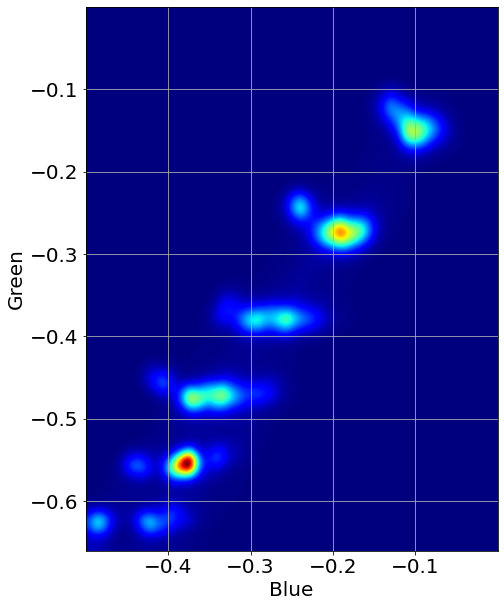

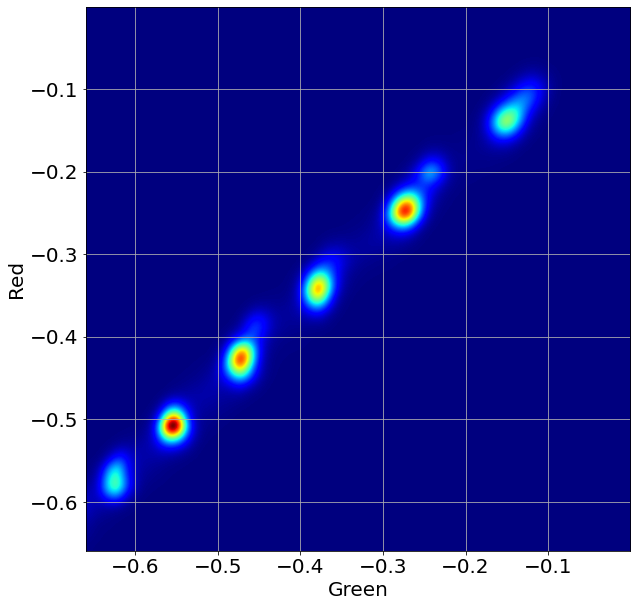

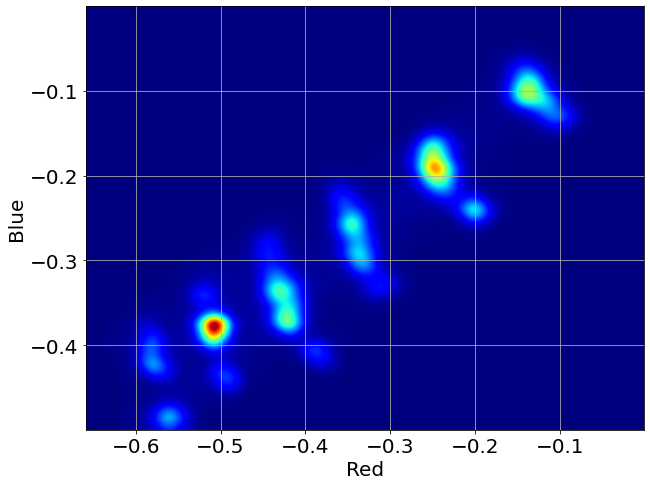

In [11]:
for i in range(3):

    # Generate some test data
    x = full_contrasts[:, i]
    y = full_contrasts[:, (i + 1) % 3]

    plt.figure(figsize=(10, 10))
    img, extent = myHeatmap(x, y, 10, bins=1000)
    plt.imshow(img, extent=extent, origin="lower", cmap=cm.jet)

    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])

    plt.grid()

    plt.savefig(f"{PLOT_SAVE_DIR}/heat_contrast_{i}.jpg", dpi=300)

    plt.show()


### Cropping the Arrays


In [8]:
# cropping the contrast array
upper_bounds = [0, 0, 0]  # B,G,R
lower_bounds = [-0.5, -0.66, -0.66]  # B,G,R
full_contrasts = full_contrasts[
    (full_contrasts[:, 0] > lower_bounds[0])
    & (full_contrasts[:, 0] < upper_bounds[0])
    & (full_contrasts[:, 1] > lower_bounds[1])
    & (full_contrasts[:, 1] < upper_bounds[1])
    & (full_contrasts[:, 2] > lower_bounds[2])
    & (full_contrasts[:, 2] < upper_bounds[2])
]

print(len(full_contrasts))


686234


## Fitting GMM for multiple components


### Fit the GM Models to the Data


In [12]:
NUM_COMPONENTS = 6
USE_ADDITIONAL_COMPONENT_FOR_NOISE = True
COV_TYPE = "full"

if USE_ADDITIONAL_COMPONENT_FOR_NOISE:
    NUM_COMPONENTS += 1

# Used to scale on of the dimensions of the ellipse
# In this case the Blue Channel
SCALING_MATRIX = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

# sample the data
sampled_full_contrasts = full_contrasts
# [
#     np.random.choice(full_contrasts.shape[0], 30000, replace=False), :
# ]

kmeans = KMeans(n_clusters=NUM_COMPONENTS, random_state=0)
kmeans.fit(sampled_full_contrasts)
all_means_kmeans = kmeans.cluster_centers_

gaussian_model = GaussianMixture(
    n_components=NUM_COMPONENTS,
    covariance_type=COV_TYPE,
    max_iter=100,
    init_params="kmeans",
    means_init=all_means_kmeans,
    n_init=10,
    tol=1e-4,
    reg_covar=1e-7,
    warm_start=False,
)

gaussian_model.fit(sampled_full_contrasts)

all_means_gauss = np.round(gaussian_model.means_, 3)
predicted_labels = gaussian_model.predict(sampled_full_contrasts)
if COV_TYPE == "tied":
    all_covariances_gauss = np.array([gaussian_model.covariances_] * NUM_COMPONENTS)
else:
    all_covariances_gauss = gaussian_model.covariances_

# scale the covariance matrix
for i in range(NUM_COMPONENTS):
    all_covariances_gauss[i] = (
        SCALING_MATRIX.T @ all_covariances_gauss[i] @ SCALING_MATRIX
    )

# Remove the additional component for noise if we used it
# It has the largest eigenvalue by default as its ellipse is the biggest
if USE_ADDITIONAL_COMPONENT_FOR_NOISE:
    max_ev = 0
    max_ev_idx = 0
    # get the eigenvalues and eigenvectors
    for idx, cov in enumerate(all_covariances_gauss):
        eig_vals, _ = np.linalg.eig(cov)
        if np.sum(eig_vals) > max_ev:
            max_ev = np.sum(eig_vals)
            max_ev_idx = idx

    # remove the largest eigenvalue
    all_covariances_gauss = np.delete(all_covariances_gauss, max_ev_idx, axis=0)
    all_means_gauss = np.delete(all_means_gauss, max_ev_idx, axis=0)
    all_means_kmeans = np.delete(all_means_kmeans, max_ev_idx, axis=0)


### Plotting the Fitted Data


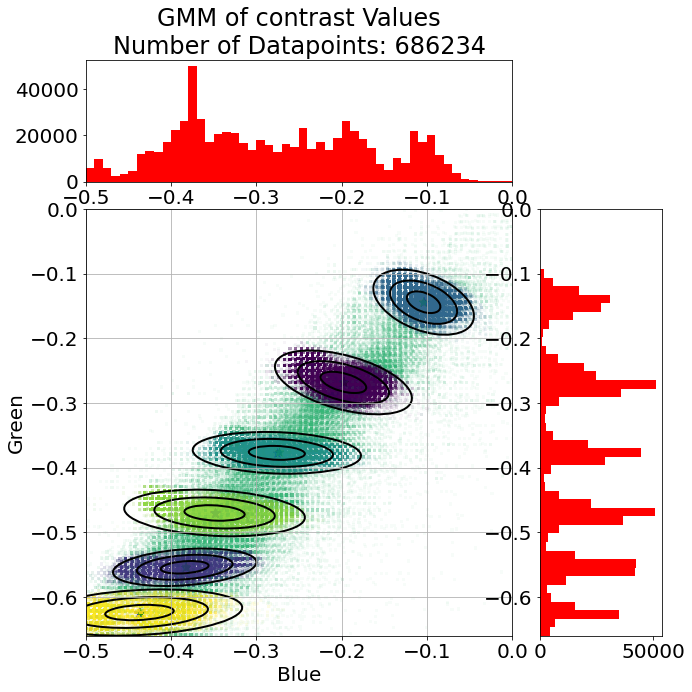

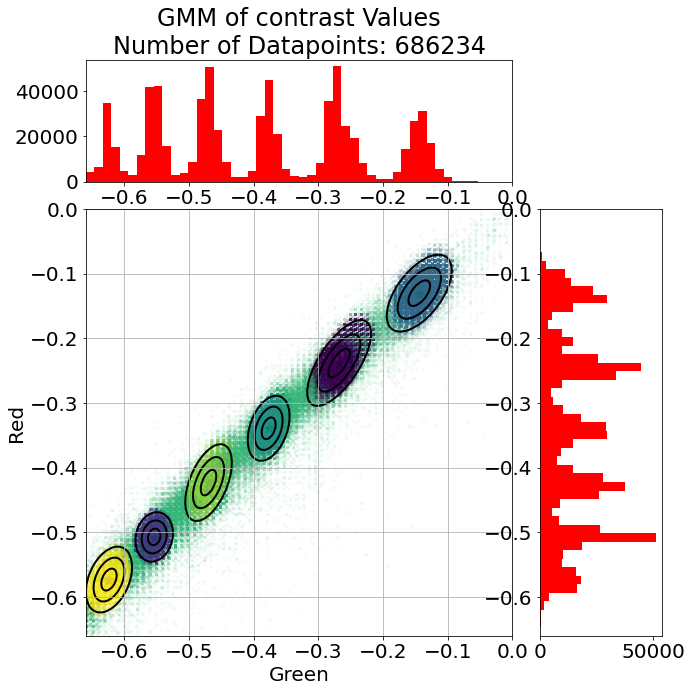

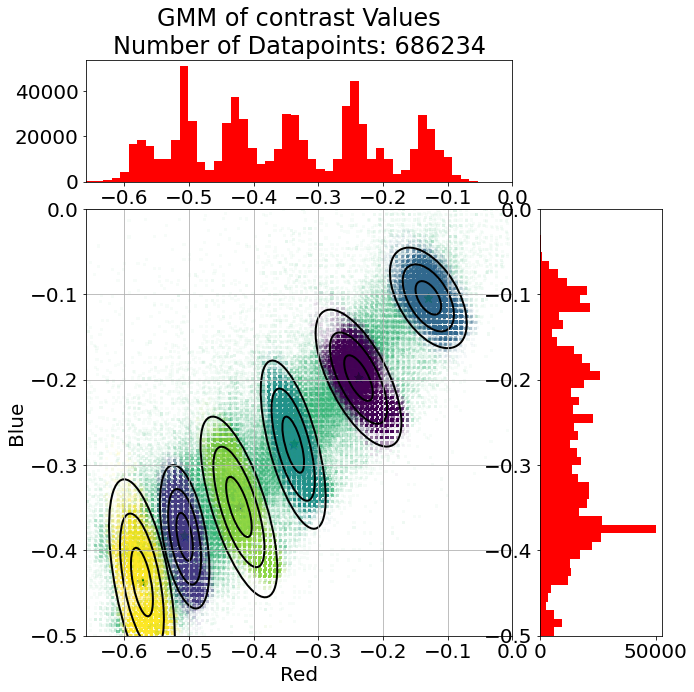

In [13]:
NUM_BINS = 50
COMPONENT_COLORS = np.array(
    ["red", "green", "blue", "cyan", "magenta", "yellow", "black"]
)

for i in [0, 1, 2]:

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    X_DATA = sampled_full_contrasts[:, [i, (i + 1) % 3]]
    gauss_means = all_means_gauss[:, [i, (i + 1) % 3]]
    km_means = all_means_kmeans[:, [i, (i + 1) % 3]]
    covariances = all_covariances_gauss[:, :, [i, (i + 1) % 3]][:, [i, (i + 1) % 3], :]

    fig = plt.figure(figsize=(10, 10))

    # Define the plot windows
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(7, 2),
        height_ratios=(2, 7),
        left=0.1,
        right=0.9,
        bottom=0.1,
        top=0.9,
        wspace=0.1,
        hspace=0.1,
    )

    # add subplots for the data
    ax = fig.add_subplot(gs[1, 0])
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

    # add the histograms
    if NUM_BINS == 0:
        bins_x = np.linspace(x_lower, x_upper, x_upper - x_lower + 1) - 0.5
        bins_y = np.linspace(y_lower, y_upper, y_upper - y_lower + 1) - 0.5
    else:
        bins_x = NUM_BINS
        bins_y = NUM_BINS
    ax_histx.hist(X_DATA[:, 0], bins=bins_x, color="r")
    ax_histy.hist(X_DATA[:, 1], bins=bins_y, orientation="horizontal", color="r")

    # add the confidence ellipse
    for j in range(gauss_means.shape[0]):
        # if j == 2:
        #     continue

        component = X_DATA[predicted_labels == j]
        component_covariance = covariances[j]

        ax.scatter(gauss_means[j, 0], gauss_means[j, 1], s=100, marker="*", c="b")
        ax.scatter(km_means[j, 0], km_means[j, 1], s=100, marker="*", c="g")

        for h in range(3):
            confidence_ellipse(
                ax,
                mean=gauss_means[j],
                cov=component_covariance,
                n_std=h + 1,
                facecolor="none",
                edgecolor="black",
            )

    ax.scatter(
        X_DATA[:, 0],
        X_DATA[:, 1],
        s=10,
        marker="s",
        alpha=0.04,
        ec="None",
        c=predicted_labels,
    )

    # ax.legend()
    ax.set_xlim(x_lower, x_upper)
    ax.set_ylim(y_lower, y_upper)
    ax.set_xlabel(COLOR_NAMES[i])
    ax.set_ylabel(COLOR_NAMES[(i + 1) % 3])
    ax.grid()
    ax_histx.set_title(
        f"GMM of contrast Values\nNumber of Datapoints: {X_DATA.shape[0]}"
    )
    plt.savefig(
        f"{PLOT_SAVE_DIR}/{COLOR_NAMES[i]}_{COLOR_NAMES[(i + 1) % 3]}.jpg", dpi=500
    )
    plt.show()


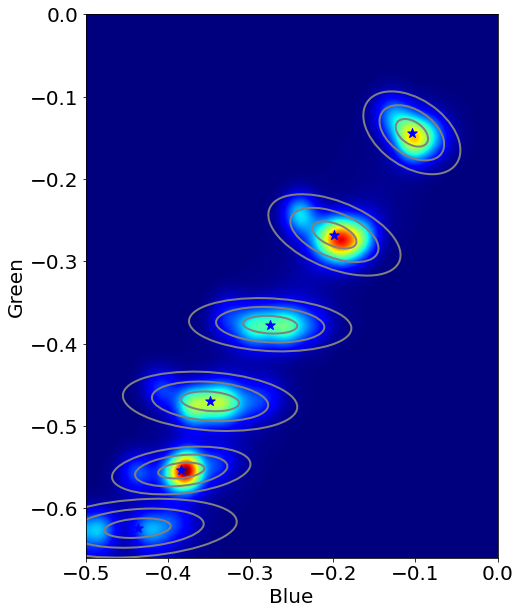

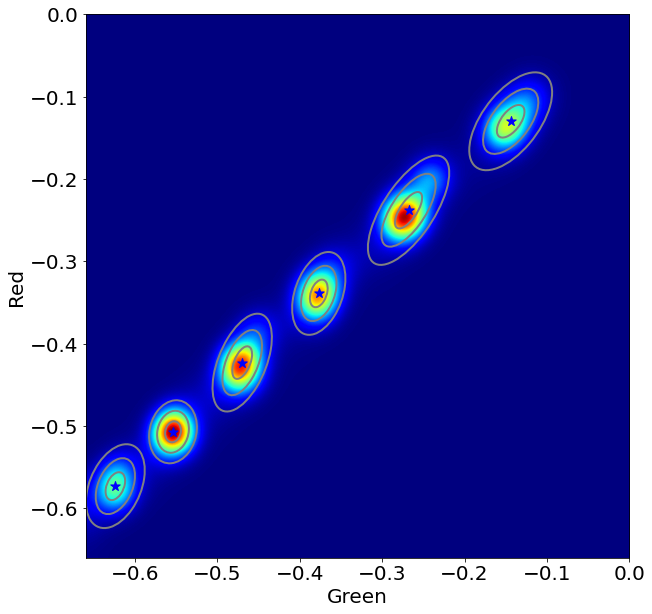

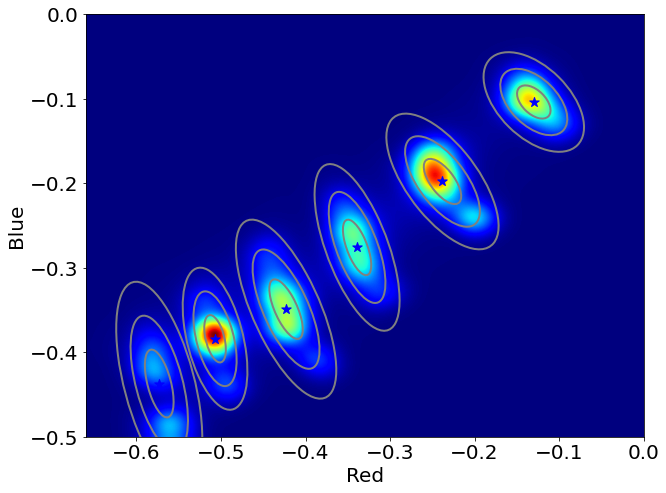

In [14]:
for i in [0, 1, 2]:

    x_lower = lower_bounds[i]
    x_upper = upper_bounds[i]
    y_lower = lower_bounds[(i + 1) % 3]
    y_upper = upper_bounds[(i + 1) % 3]

    X_DATA = sampled_full_contrasts[:, [i, (i + 1) % 3]]
    gauss_means = all_means_gauss[:, [i, (i + 1) % 3]]
    km_means = all_means_kmeans[:, [i, (i + 1) % 3]]
    covariances = all_covariances_gauss[:, :, [i, (i + 1) % 3]][:, [i, (i + 1) % 3], :]

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    img, extent = myHeatmap(
        X_DATA[:, 0],
        X_DATA[:, 1],
        20,
        bins=1000,
        extent=[x_lower, x_upper, y_lower, y_upper],
    )
    plt.imshow(img, extent=extent, origin="lower", cmap=cm.jet)

    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])

    # add the confidence ellipse
    for j in range(all_means_gauss.shape[0]):
        # if j == 2:
        #     continue

        component_covariance = covariances[j]
        component_mean = gauss_means[j]

        for h in range(3):
            confidence_ellipse(
                ax,
                mean=component_mean,
                cov=component_covariance,
                n_std=h + 1,
                facecolor="none",
                edgecolor="grey",
            )

    plt.scatter(gauss_means[:, 0], gauss_means[:, 1], s=100, marker="*", c="b")

    # plt.legend()
    plt.xlim(x_lower, x_upper)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(COLOR_NAMES[i])
    plt.ylabel(COLOR_NAMES[(i + 1) % 3])
    plt.savefig(
        f"{PLOT_SAVE_DIR}/heat_{COLOR_NAMES[i]}_{COLOR_NAMES[(i + 1) % 3]}_Ellipse.jpg",
        dpi=500,
    )
    plt.show()


In [14]:
# calculate the correlation matrix from the covariance matrix
def correlation_matrix(covariance_matrix):
    corr_matrix = np.zeros(covariance_matrix.shape)
    for i in range(covariance_matrix.shape[0]):
        for j in range(covariance_matrix.shape[1]):
            corr_matrix[i, j] = covariance_matrix[i, j] / np.sqrt(
                covariance_matrix[i, i] * covariance_matrix[j, j]
            )
    return corr_matrix


for i in range(all_means_gauss.shape[0]):
    print(f"\nComponent {i+1}")
    print(all_means_gauss[i])
    corr_matrix = correlation_matrix(all_covariances_gauss[i])
    print(np.round(corr_matrix, 2))



Component 1
[-0.358 -0.562 -0.523]
[[ 1.    0.31 -0.2 ]
 [ 0.31  1.    0.18]
 [-0.2   0.18  1.  ]]

Component 2
[-0.169 -0.274 -0.251]
[[ 1.    0.18 -0.  ]
 [ 0.18  1.    0.16]
 [-0.    0.16  1.  ]]

Component 3
[-0.079 -0.152 -0.138]
[[ 1.    0.07 -0.07]
 [ 0.07  1.    0.11]
 [-0.07  0.11  1.  ]]

Component 4
[-0.239 -0.384 -0.354]
[[ 1.    0.14 -0.22]
 [ 0.14  1.    0.14]
 [-0.22  0.14  1.  ]]

Component 5
[-0.307 -0.478 -0.442]
[[ 1.    0.23 -0.16]
 [ 0.23  1.    0.16]
 [-0.16  0.16  1.  ]]

Component 6
[-0.393 -0.63  -0.59 ]
[[ 1.    0.3  -0.15]
 [ 0.3   1.    0.18]
 [-0.15  0.18  1.  ]]


## Generate the JSON


In [15]:
import json

component_dict = {}

for component in range(all_means_gauss.shape[0]):
    component_dict[component] = {}
    component_dict[component]["contrast"] = {
        "r": all_means_gauss[component][2],
        "g": all_means_gauss[component][1],
        "b": all_means_gauss[component][0],
    }
    component_dict[component]["covariance_matrix"] = all_covariances_gauss[
        component
    ].tolist()
    component_dict[component]["color_radius"] = {
        "r": 0.06,
        "g": 0.06,
        "b": 0.1,
    }

with open("gaussian_mixture_model_contrast_data.json", "w") as f:
    json.dump(component_dict, f)
